<a href="https://colab.research.google.com/github/ankesh86/IntroductionToMachineLearning/blob/main/ASSGN_q3_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy.stats import norm, multivariate_normal
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
feature_df = pd.read_csv("X_train.txt", header=None, delim_whitespace=True)
label_df = pd.read_csv("y_train.txt", header=None, delim_whitespace=True)
headers =  pd.read_csv("features.txt", header=None, delim_whitespace=True)

column_names = headers.iloc[:, 1].tolist()
# Now assign these names to the columns of feature_df
feature_df.columns = column_names
# Optionally, you can display the first few rows to confirm the column names are set correctly
print(feature_df.head())

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

In [ ]:
def regularized_cov(X, lambda_reg):
    # Note: Ensure the input X is in the form where rows are observations
    sigma = np.cov(X, rowvar=False)  # rowvar=False to treat rows as observations
    n_features = X.shape[1]
    sigma += lambda_reg * np.eye(n_features)
    return sigma

In [ ]:
# Access rows/columns by indexing
X = feature_df.to_numpy()
Y = label_df.to_numpy()

# Define a label encoder to encode labels numerically
le = preprocessing.LabelEncoder()
labels = le.fit_transform(Y)  # Fit and transform in one step

# Estimate class priors
unique_classes, counts = np.unique(Y, return_counts=True)
class_priors = counts / counts.sum()  # Normalize counts to sum to 1
num_classes = len(unique_classes)

# Print results to verify
print("Class Priors:", class_priors)
print("Number of Classes:", num_classes)

Class Priors: [0.16675734 0.14594668 0.13411317 0.17491839 0.18688792 0.1913765 ]
Number of Classes: 6


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Compute mean vectors
mean_vectors = np.array([X[labels == i].mean(axis=0) for i in range(num_classes)])

# Regularization parameter
lambda_reg = 5 / X.shape[1]

# Compute regularized covariance matrices for each class
regularized_cov_matrices = np.array([
    regularized_cov(X[labels == i], lambda_reg)
    for i in range(num_classes)
])

# Number of samples per class
N_per_l = counts
print(lambda_reg)

0.008912655971479501


In [ ]:
gmm = {
    'priors': class_priors,
    'mu': mean_vectors,
    'Sigma': regularized_cov_matrices
}

print(N_per_l)


[1226 1073  986 1286 1374 1407]


In [ ]:
def calculate_class_conditional_likelihoods(X, gmm_params, num_classes):
    """
    Compute the likelihood of data given each class.

    Args:
        X (np.ndarray): The dataset for which likelihoods are calculated.
        gmm_params (dict): Gaussian mixture model parameters with keys 'mu', 'Sigma'.
        num_classes (int): Number of unique classes.

    Returns:
        np.ndarray: Likelihoods of each class given the data.
    """
    return np.array([
        multivariate_normal.pdf(X, mean=gmm_params['mu'][i], cov=gmm_params['Sigma'][i])
        for i in range(num_classes)
    ])
def calculate_posteriors(likelihoods, priors):
    """Calculate posterior probabilities using Bayes' rule."""
    priors_diagonal = np.diag(priors)
    return priors_diagonal.dot(likelihoods)

def calculate_risks(posteriors, loss_matrix):
    """Calculate risks for each class and sample."""
    return loss_matrix.dot(posteriors)

def classify(risks):
    """Classify data points into the class with minimum risk."""
    return np.argmin(risks, axis=0)

def perform_erm_classification(X, Lambda, gmm_params, num_classes):
    """
    Perform Empirical Risk Minimization (ERM) classification based on Gaussian mixture model parameters.

    Args:
        X (np.ndarray): Data points to classify.
        Lambda (np.ndarray): Loss matrix.
        gmm_params (dict): Parameters of the Gaussian Mixture Model including 'mu', 'Sigma', and 'priors'.

    Returns:
        np.ndarray: Predicted class labels for each data point.
    """
    #num_classes = len(gmm_params['priors'])  # Explicitly calculating the number of classes
    likelihoods = calculate_class_conditional_likelihoods(X, gmm_params, num_classes)
    posteriors = calculate_posteriors(likelihoods, gmm_params['priors'])
    risks = calculate_risks(posteriors, Lambda)
    return classify(risks)

In [ ]:
%matplotlib widget

from sys import float_info  # Threshold smallest positive floating value

import matplotlib.pyplot as plt # For general plotting

Confusion Matrix (rows: Predicted class, columns: True class):


Text(0.5, 0, 'True Labels')

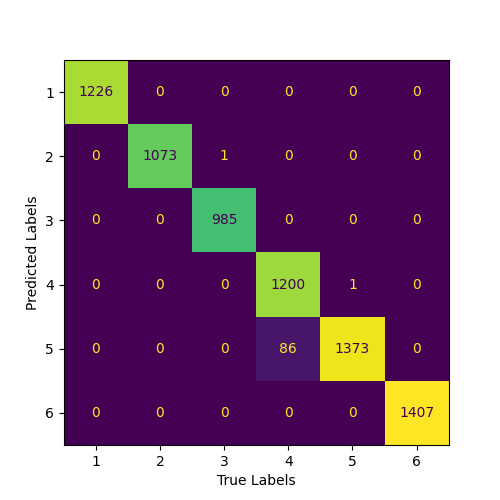

In [ ]:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((num_classes, num_classes)) - np.eye(num_classes)

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(X, Lambda, gmm, num_classes)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
fig, ax = plt.subplots(figsize=(5, 5))
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, labels, ax=ax, display_labels=['1', '2', '3', '4', '5', '6'], colorbar=False)
plt.ylabel('Predicted Labels')
plt.xlabel('True Labels')

In [ ]:
# Total number of rows/samples
N = len(feature_df.index)

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total number of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

Total number of Misclassified Samples: 88
Empirically Estimated Probability of Error: 0.0120


In [ ]:
#HAR_df = pd.concat([X, Y], axis=1)
label_df.rename(columns={label_df.columns[0]: 'label'}, inplace=True)
HAR_df = pd.concat([feature_df, label_df], axis=1)

numeric_HAR_df = HAR_df.select_dtypes(include=[np.number])
corr_matrix = numeric_HAR_df.corr()
top_5_correlations = corr_matrix["label"].sort_values(ascending=False).head(5)

print("Top 5 positive correlations with 'label':")
print(top_5_correlations)

Top 5 positive correlations with 'label':
label                   1.000000
tBodyAccJerk-min()-Y    0.788595
tBodyAccJerk-min()-X    0.786288
tBodyAcc-min()-Y        0.771205
tBodyGyro-min()-Z       0.758051
Name: label, dtype: float64


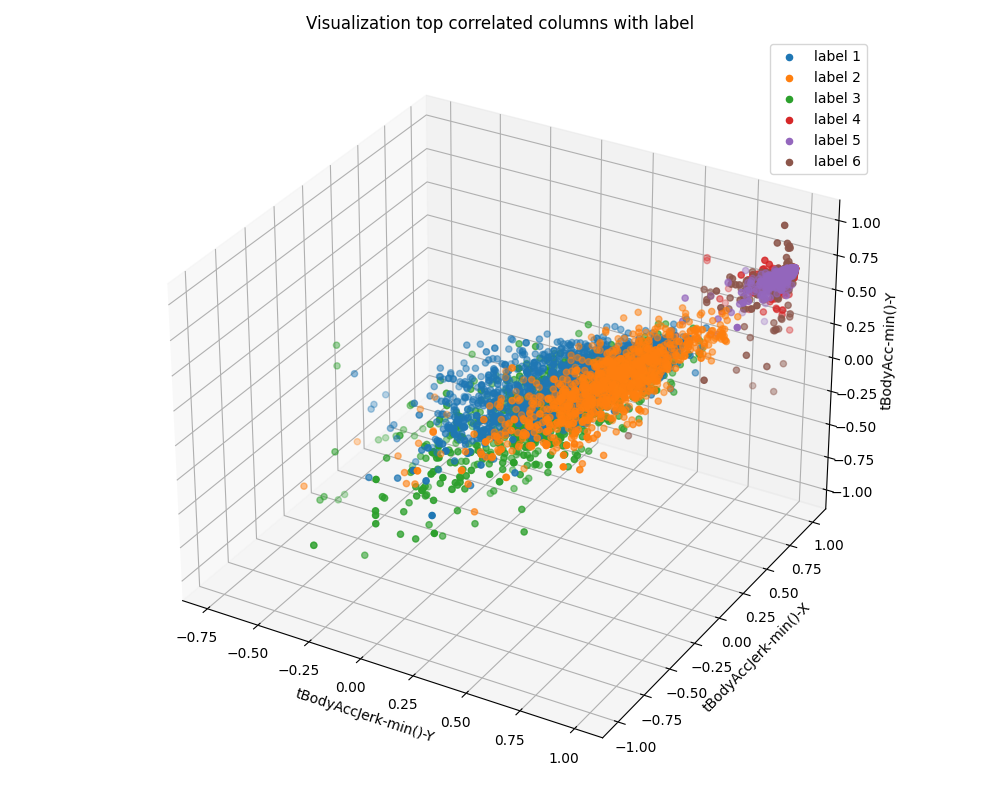

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming wine_df is already defined and loaded
fig = plt.figure(figsize=(10, 8))  # Define the figure size
ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot

# Get unique qualities and sort them
unique_qualities = np.sort(HAR_df['label'].unique())

# Iterate through the sorted unique qualities
for q in unique_qualities:
    subset = HAR_df[HAR_df['label'] == q]
    ax.scatter(subset['tBodyAccJerk-min()-Y'], subset['tBodyAccJerk-min()-X'], subset['tBodyAcc-min()-Y'], label=f"label {q}")

# Set labels for each axis based on the features being plotted
ax.set_xlabel("tBodyAccJerk-min()-Y")
ax.set_ylabel("tBodyAccJerk-min()-X")
ax.set_zlabel("tBodyAcc-min()-Y")

# Add a title and a legend to the plot
plt.title("Visualization top correlated columns with label")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


# **PCA**

In [ ]:
from sklearn.decomposition import PCA

Explained variance ratio:  [0.6255444  0.04913023 0.04121467]


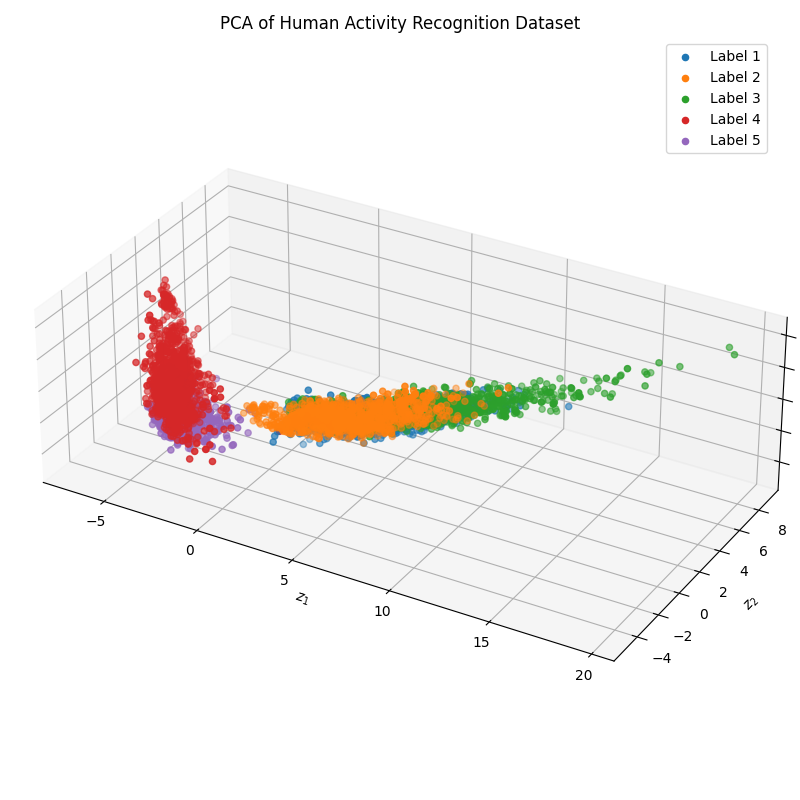

In [ ]:
fig = plt.figure(figsize=(8,8))

ax_pca = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)  # n_components is how many PCs we'll keep
X_fit = pca.fit(X)  # Is a fitted estimator, not actual data to project
Z = pca.transform(X)

# first principal component accounts for approximately 62.55% of the variance in the data.
print("Explained variance ratio: ", pca.explained_variance_ratio_)

for q in range(unique_qualities[0], unique_qualities[-1]):
    ax_pca.scatter(Z[HAR_df['label']==q, 0],
                      Z[HAR_df['label']==q, 1],
                      Z[HAR_df['label']==q, 2], label="Label {}".format(q))

ax_pca.set_xlabel(r"$z_1$")
ax_pca.set_ylabel(r"$z_2$")
ax_pca.set_zlabel(r"$z_3$")

ax_pca.set_box_aspect((np.ptp(Z[:, 0]), np.ptp(Z[:, 1]), np.ptp(Z[:, 2])))

plt.title("PCA of Human Activity Recognition Dataset")
plt.legend()
plt.tight_layout()
plt.show()